## Задача

**"Обучи несколько бустингов на 3-х фолдах, выбери лучшие, усредни предсказания"**
Если вы думает, что это задание - больная фантазия авторов, то нет - это, как раз, реальные кейсы с соревнований. Можно назвать это задание подготовкой к модулю про блендинг и стэккинг.

Датасеты: `quickstart_train.csv` и `quickstart_test.csv`

Регрессионный таргет: столбец `target_reg` , метрика `RMSE`

**Модели**, которые необходимо обучить:

- CatBoostRegressor
- LightGBMRegressor (goss)
- XGBoostRegressor (dart)

**Бонусом**, для тех кому покажется мало, можно обучить ещё 3 модели (не влияет на итоговый балл):

- CatBoostRegressor с другим random_seed
- LightGBMRegressor (dart)
- XGBoostRegressor (gbtree)

В этом случае усредняем лучшие фолды от 6 моделей.

**Дополнительные условия**:

- Все модели обучаем на 3-х фолдах
- Выбираем лучший фолд от каждой модели (получаем 6 лучших моделей)
- Обязательно должна быть добавлена ячейка с сохранением 6 лучших моделей
- Делаем итоговое предсказание на тестовом датасете, усреднив предсказание от 6 лучших моделей
- Сохраняем в `submission.csv` только колонки `car_id` и `target_reg`
- В конце добавляем небольшой текстовый блок с выводами
- Желательно, чтобы на выполнение всего ноутбука уходило не более 30 мин.
- Не добавляем новые признаки
- Не используем GPU
- Не используем Optuna

Что можно использовать (но не обязательно)?
- Feature Selection
- Object importance
- Подбор гиперпараметров
- Графику
- Колбэки, шедулеры, кастомы

Формат сдачи:

- В текстовом поле вводим ссылки на онлайн версию jupyter ноутбука (GoogleСolab, Kaggle) с выполненным заданием, и публичную ссылку на файлхостинг (GoogleDrive, ЯндексДиск или др.) с оригиналом ноутбука. (проверяем, что они работают).
- Во вложение добавляем тот же ноутбук, сохраненный в формате pdf с аутпутами всех ячеек (не более 5 Mb).
- В следующем шаге отправляем получившийся CSV файл с предсказаниями. Можно использовать его, как аналог лидерборда, чтобы узнавать скор предсказаний.


**Критерии оценки (максимум 10 баллов за задание):**

**Оформление (3 балла)**
- прослеживается логика в последовательности решения задачи; в неочевидных местах добалены поясняющие комментарии и маркдаун ячейки. ноутбук не пергружен лишней информацией, огромными простынями аутпутов ячеек (настраиваем verbose, скрываем служебную информацию после установки библиотек)
- хороший codestyle: код соответствует PEP 8 и DRY, названия переменных и функций понятны, либо соответствуют общепринятым нормам (train, test, model, pd, xgb и.т.п.)
- в конце присутствуют выводы о проделанной работе<br>

**Решение задачи и выполнение доп. условий (3 балла)**<br>
- ноутбук выполняется до конца без ошибок (присутствуют все аутпуты в пдф)
- обучены все необходимые модели и выполнены доп. условия
- проведена работа над воспроизводимостью (зафиксированы все random seeds)
- присутствуют и отрабатывают ячейки для сохранения лучших моделей и итогового файла с предсказанием<br>

 **Использование возможностей фрэймворка (2 балла)**<br>
- датсеты загружаются с помощью соответствующих классов (Pool, Dmatrix, Dataset)
- используется early_stopping, многопоточность (n_threads) и пр.
- правильная подготовка категориальных признаков для каждой модели.<br>

 **Дополнительные баллы (макс. 2 балла)**<br>
- 1 балл, если проводился подбор гиперпараметров;
- 1 балл, если использованы минимум 2 вида графики и на основе её сделаны какие-либо выводы (не просто график ради картинки красивой, а с пользой для дела);
- 1 балл, если проводился feature selection или object selection
- 1 балл, если использовались scheduler или custom callbacks

## Подключение библиотек и загрузка данных


In [ ]:
!pip install catboost lightgbm xgboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


In [ ]:
!pip install shap -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.4 MB/s eta 0:00:00


In [ ]:
!pip install phik -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


import shap
shap.initjs()

from catboost import CatBoostRegressor, Pool

import lightgbm as lgb
from lightgbm import LGBMRegressor, Dataset

import xgboost as xgb
from xgboost import XGBRegressor, DMatrix

import phik
from phik.report import plot_correlation_matrix
from phik import report

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv')

In [ ]:
train.corr()

,car_rating,year_to_start,riders,year_to_work,target_reg,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
car_rating,1.000000,-0.016672,-0.013615,-0.017544,0.022625,0.015676,0.003108,0.056608,-0.000757,0.027673,NaN,0.000972
year_to_start,-0.016672,1.000000,0.986746,0.059072,0.006814,0.004304,0.005302,0.004889,-0.031056,-0.024677,NaN,-0.076168
riders,-0.013615,0.986746,1.000000,0.048270,0.003588,0.004255,0.009759,0.006125,-0.035651,-0.026698,NaN,-0.074768
year_to_work,-0.017544,0.059072,0.048270,1.000000,0.033645,0.003085,0.000682,-0.004758,-0.014827,0.022986,NaN,-0.060119
target_reg,0.022625,0.006814,0.003588,0.033645,1.000000,-0.014603,-0.075035,0.040122,0.421000,0.034966,NaN,-0.216736
mean_rating,0.015676,0.004304,0.004255,0.003085,-0.014603,1.000000,-0.132011,0.363178,-0.576586,-0.006162,NaN,0.039674
distance_sum,0.003108,0.005302,0.009759,0.000682,-0.075035,-0.132011,1.000000,-0.059760,0.126899,-0.002942,NaN,0.045472
rating_min,0.056608,0.004889,0.006125,-0.004758,0.040122,0.363178,-0.059760,1.000000,-0.272852,-0.008544,NaN,0.005190
speed_max,-0.000757,-0.031056,-0.035651,-0.014827,0.421000,-0.576586,0.126899,-0.272852,1.000000,-0.024974,NaN,-0.046310
user_ride_quality_median,0.027673,-0.024677,-0.026698,0.022986,0.034966,-0.006162,-0.002942,-0.008544,-0.024974,1.000000,NaN,-0.001559


interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']


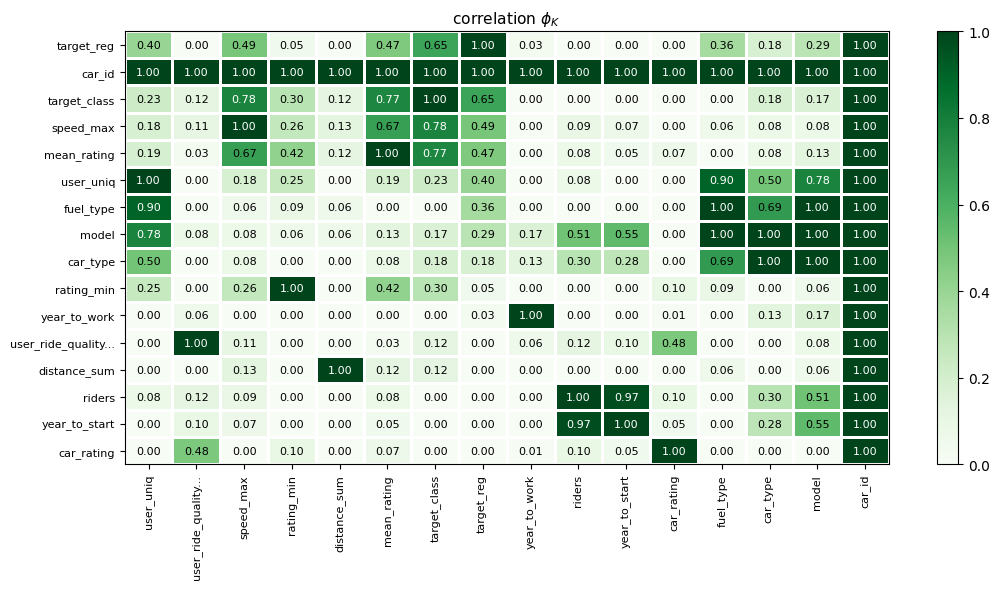

In [ ]:
phik_overview = train.phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

**Переменные**

In [ ]:
RANDOM_STATE = 1337

## Данные

Всегда полезно посмотреть на распределение признаков.

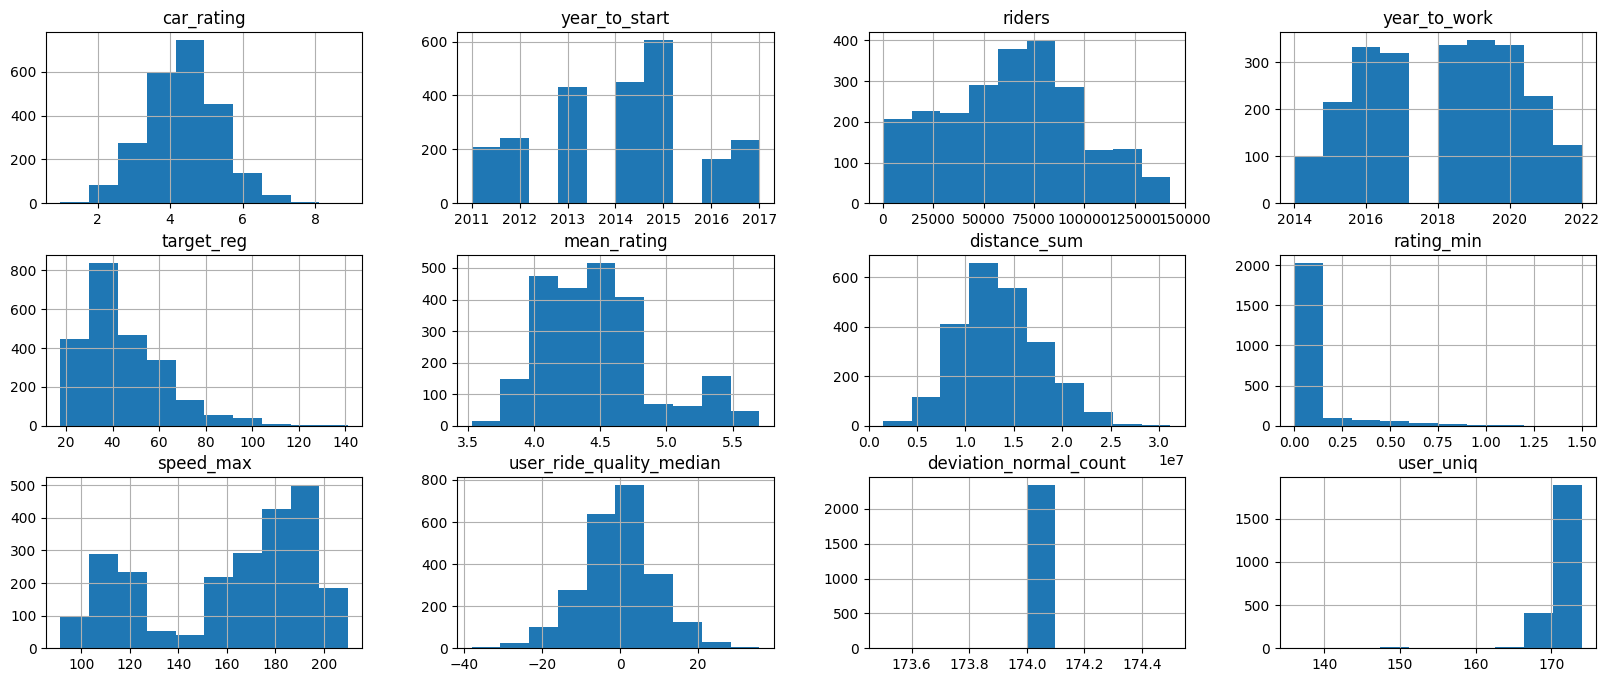

In [ ]:
train.hist(figsize=(20, 8), layout = (-1, 4));

Заметим, что признак deviation_normal_count - константа. Удалим его.

In [ ]:
cat_features = ['model', 'car_type', 'fuel_type']
targets = ['target_reg', 'target_class']
feature2drop = ['car_id', 'deviation_normal_count']

## Вспомогательные функции

Возьмём функции для обучения и подбора гиперпараметров из шаблона.

In [ ]:
def train_model(algorithm,
                X,
                y,
                early_stopping_rounds,
                init_params=None,
                cat_features=None,
                random_seed=RANDOM_STATE
    ):
    scores = []
    models = []

    kf = KFold(n_splits=3, shuffle=True, random_state=random_seed)

    print(f"========= TRAINING {algorithm.__name__} =========")

    for num_fold, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_eval = X.iloc[train_index], X.iloc[val_index]
        y_train, y_eval = y.iloc[train_index], y.iloc[val_index]

        if init_params is not None:
            model = algorithm(**init_params)
        else:
            model = algorithm()

        if algorithm.__name__ == 'CatBoostRegressor':
            train_dataset = Pool(X_train, y_train, cat_features=cat_features)
            eval_dataset = Pool(X_eval, y_eval, cat_features=cat_features)

            model.fit(train_dataset,
                      eval_set=eval_dataset,
                      verbose=0,
                      early_stopping_rounds=early_stopping_rounds)

        elif algorithm.__name__ == 'LGBMRegressor':
            train_dataset = Dataset(X_train, label=y_train)
            eval_dataset = Dataset(X_eval, label=y_eval)

            model = lgb.train(params=init_params,
                              train_set=train_dataset,
                              valid_sets=(eval_dataset),
                              categorical_feature=cat_features)

        elif algorithm.__name__ == 'XGBRegressor':
            train_dataset = DMatrix(X_train, label=y_train)
            eval_dataset = DMatrix(X_eval, label=y_eval)

            model = xgb.train(params=init_params,
                              dtrain=train_dataset,
                              evals=[(train_dataset, 'dtrain'), (eval_dataset, 'dtest')],
                              verbose_eval=False,
                              early_stopping_rounds=early_stopping_rounds)

            X_eval = eval_dataset

        y_pred = model.predict(X_eval)
        score = np.sqrt(mean_squared_error(y_eval, y_pred))

        models.append(model)
        scores.append(score)

        print(f'FOLD {num_fold}: SCORE {score}')

    mean_kfold_score = np.mean(scores, dtype="float16") -  np.std(scores, dtype="float16")
    print("\nMEAN RMSE SCORE", mean_kfold_score)

    best_model = models[np.argmin(scores)]

    return mean_kfold_score, best_model

In [ ]:
def tuning_hyperparams(algorithm,
                       X,
                       y,
                       init_params,
                       fit_params,
                       grid_params,
                       n_iter,
                       cv=3,
                       random_state=RANDOM_STATE,
    ):

    estimator = algorithm(**init_params)

    model = RandomizedSearchCV(estimator=estimator,
                               param_distributions=grid_params,
                               n_iter=n_iter,
                               cv=cv,
                               scoring='neg_root_mean_squared_error',
                               n_jobs=-1,
                               verbose=0,
                               random_state=random_state
    )

    model.fit(X, y, **fit_params)

    return model.best_params_ | init_params

## 🐈Catboost

In [ ]:
X = train.drop(targets + feature2drop, axis=1)
y = train['target_reg']

In [ ]:
cb_init_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': RANDOM_STATE
}

cb_score, best_model = train_model(
    algorithm=CatBoostRegressor,
    X=X, y=y,
    init_params=cb_init_params,
    early_stopping_rounds=100,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

best_model.save_model('catboost_raw.cbm') #сохраняем лучшую модель


========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.466705138669594
FOLD 1: SCORE 12.137502567452728
FOLD 2: SCORE 11.037368003441905

MEAN RMSE SCORE 11.1


Предсказание для лидерборда.

In [ ]:
cb_test_pred = best_model.predict(test.drop(targets + feature2drop, axis=1, errors='ignore'))

pd.DataFrame({'car_id': test['car_id'], 'target_reg': cb_test_pred}).to_csv('cb_pred_raw.csv', index=False)

Получили RMSE = 11.9 на лидерборде.

### Подбор гиперпараметров

Подбор гиперпараметров будет проводить с помощью **RandomizedSearchCV** для экономии времени.

In [ ]:
cb_fit_params = {
    'cat_features': cat_features,
    'verbose': 0,
    'early_stopping_rounds': 50
}


cb_grid_params = {
    'depth': [4, 8, 12],
    'l2_leaf_reg': [1, 2, 3],
    'random_strength': [0.05, 0.1, 0.15],
    'colsample_bylevel': [0.5, 0.8, 1.0],
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
    'min_data_in_leaf': [1, 3, 5],
    'max_bin': [128, 256, 512],
    'bootstrap_type': ['No','Bayesian','Bernoulli','Poisson'],
} #~6k вариантов признаков


catboost_params_after_tuning = tuning_hyperparams(algorithm=CatBoostRegressor,
                                                  X=X, y=y,
                                                  init_params=cb_init_params,
                                                  fit_params=cb_fit_params,
                                                  grid_params=cb_grid_params,
                                                  n_iter=20,
                                                  cv=3,
                                                  random_state=RANDOM_STATE
)

catboost_params_after_tuning

{'random_strength': 0.1,
 'min_data_in_leaf': 1,
 'max_bin': 256,
 'l2_leaf_reg': 3,
 'grow_policy': 'SymmetricTree',
 'depth': 8,
 'colsample_bylevel': 0.8,
 'bootstrap_type': 'Bayesian',
 'loss_function': 'RMSE',
 'eval_metric': 'RMSE',
 'thread_count': -1,
 'task_type': 'CPU',
 'random_seed': 1337}

Обучаем модель с лучшими параметрами.

In [ ]:
cb_tuning_score, best_model = train_model(algorithm=CatBoostRegressor,
                                               X=X, y=y,
                                               early_stopping_rounds=50,
                                               init_params=catboost_params_after_tuning,
                                               cat_features=cat_features,
                                               random_seed=RANDOM_STATE)

best_model.save_model('catboost_tuned.cbm') #сохраняем лучшую модель

========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.610723726592475
FOLD 1: SCORE 12.102903834086895
FOLD 2: SCORE 11.048687605661422

MEAN RMSE SCORE 11.16


Предсказание для лидерборда

In [ ]:
cb_test_pred = best_model.predict(test.drop(targets + feature2drop, axis=1, errors='ignore'))

pd.DataFrame({'car_id': test['car_id'], 'target_reg': cb_test_pred}).to_csv('cb_pred_tuned.csv', index=False)

Получили RMSE = 11.9 на лидерборде.

### Feature Selection

Сначала посмотрим на каких признаках основывается модель.

In [ ]:
feature_importances = best_model.get_feature_importance()
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False, ignore_index=True)
feature_importances_df

,Feature,Importance
0,speed_max,31.710542
1,mean_rating,27.113375
2,rating_min,13.000151
3,distance_sum,4.633472
4,car_type,3.971038
5,riders,3.850385
6,user_uniq,3.696080
7,user_ride_quality_median,3.347872
8,car_rating,2.569476
9,fuel_type,2.520624


Отберём 3 самых неважных признака по индексу Шепли.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

selected_features_catboost = best_model.select_features(train_pool,
                                               eval_set=val_pool,
                                               algorithm='RecursiveByShapValues',
                                               features_for_select=X_train.columns,
                                               num_features_to_select=10,
                                               steps=1,
                                               train_final_model=False,
                                               logging_level='Silent')['selected_features_names']
selected_features_catboost

['model',
 'car_type',
 'fuel_type',
 'year_to_work',
 'mean_rating',
 'distance_sum',
 'rating_min',
 'speed_max',
 'user_ride_quality_median',
 'user_uniq']

Видим, что самые неважные по мнению модели признаки не являются признаками с самым низким значением индекса Шепли. Можно предположить, что модель основывается не на самых важных признаках. Удалим несколько признаков и обучим модель ещё раз.

In [ ]:
X = train[selected_features_catboost].drop(targets + feature2drop, axis=1, errors='ignore')
y = train['target_reg']

In [ ]:
cb_init_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'thread_count': -1,
    'task_type': 'CPU',
    'random_seed': RANDOM_STATE
}

cb_score, best_model = train_model(
    algorithm=CatBoostRegressor,
    X=X, y=y,
    init_params=cb_init_params,
    early_stopping_rounds=100,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

best_model.save_model('catboost_raw_feature_selected.cbm') #сохраняем лучшую модель

========= TRAINING CatBoostRegressor =========
FOLD 0: SCORE 11.472824878074448
FOLD 1: SCORE 12.10789677824525
FOLD 2: SCORE 10.971369908986416

MEAN RMSE SCORE 11.055


Предсказание для лидерборда.

In [ ]:
cb_test_pred = best_model.predict(test.drop(['target_class'] + feature2drop, axis=1))

pd.DataFrame({'car_id': test['car_id'], 'target_reg': cb_test_pred}).to_csv('cb_pred_feature_selected.csv', index=False)

Получили RMSE = 11.8 на лидерборде.


### Вывод(маленький)

1) Подбор гиперпараметров улучшения не дал. Возможно из-за маленького перебора.

2) Значительного улучшения метрики удалось добиться отбором фичей. Видимо, модель основывалась не на самых информативных признаках.

## 🌈LightGBM (goss)

In [ ]:
train_encoded = train.copy()
test_encoded = test.copy()

# инициализируем LabelEncoder для каждого категориального признака
label_encoders = {}
for feature in cat_features:
    label_encoders[feature] = LabelEncoder()

# кодирование категориальных признаков для тренировочного набора данных
for feature in cat_features:
    train_encoded[feature] = label_encoders[feature].fit_transform(train[feature])

# кодирование категориальных признаков для тестового набора данных
for feature in cat_features:
    test_encoded[feature] = label_encoders[feature].transform(test[feature])

X_lgb = train_encoded.drop(targets + feature2drop, axis=1, errors='ignore')
y = train_encoded['target_reg']

In [ ]:
lgb_init_params = {
    'boosting_type': 'goss',
    'n_jobs': -1,
    'metric': 'rmse',
    'objective': 'rmse',
    'random_state': RANDOM_STATE,
    'verbosity': -1,
    'device': 'cpu',
}


lgb_score, best_model = train_model(
    algorithm=LGBMRegressor,
    X=X_lgb, y=y,
    init_params=lgb_init_params,
    early_stopping_rounds=50,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

best_model.save_model('lightgbm_raw.txt') #сохраняем модель

========= TRAINING LGBMRegressor =========
FOLD 0: SCORE 12.526947274572816
FOLD 1: SCORE 12.884131206448824
FOLD 2: SCORE 11.744909694802649

MEAN RMSE SCORE 11.91


Предсказание для лидерборда.

In [ ]:
lgb_test_pred = best_model.predict(test_encoded.drop(targets + feature2drop, axis=1, errors='ignore'))

pd.DataFrame({'car_id': test['car_id'], 'target_reg': lgb_test_pred}).to_csv('lgb_pred_raw.csv', index=False)

Получили RMSE = 12.6 на лидерборде.

### Подбор гиперпараметров

In [ ]:
lgb_fit_params = {
    'eval_metric': 'rmse',
    'categorical_feature': cat_features
}


lgb_grid_params = {'learning_rate': [0.02, 0.05, 0.08, 0.1],
    'reg_lambda': [0, 0.25, 0.5, 1],
    'num_leaves': [10, 15, 20, 25],
    'max_bin': [25, 40, 50, 60, 75],
} #~320 вариантов


lgb_params_after_tuning = tuning_hyperparams(algorithm=LGBMRegressor,
                                             X=X_lgb, y=y,
                                             init_params=lgb_init_params,
                                             fit_params=lgb_fit_params,
                                             grid_params=lgb_grid_params,
                                             n_iter=20,
                                             cv=3,
                                             random_state=RANDOM_STATE
)

lgb_params_after_tuning

{'reg_lambda': 1,
 'num_leaves': 15,
 'max_bin': 75,
 'learning_rate': 0.05,
 'boosting_type': 'goss',
 'n_jobs': -1,
 'metric': 'rmse',
 'objective': 'rmse',
 'random_state': 1337,
 'verbosity': -1,
 'device': 'cpu'}

Обучаем модель с лучшими параметрами.

In [ ]:
lgb_tuning_score, best_model = train_model(
    algorithm=LGBMRegressor,
    X=X_lgb, y=y,
    init_params=lgb_params_after_tuning,
    early_stopping_rounds=50,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

best_model.save_model('lightgbm_tuned.txt') #сохраняем модель

========= TRAINING LGBMRegressor =========
FOLD 0: SCORE 12.018495707112436
FOLD 1: SCORE 12.290440363491479
FOLD 2: SCORE 11.208105950759972

MEAN RMSE SCORE 11.375


Предсказание для лидерборда.

In [ ]:
lgb_test_pred = best_model.predict(test_encoded.drop(targets + feature2drop, axis=1, errors='ignore'))

pd.DataFrame({'car_id': test['car_id'], 'target_reg': lgb_test_pred}).to_csv('lgb_pred_tuned.csv', index=False)

Получили RMSE = 12.2 на лидерборде.

### Feature Selection

Сначала посмотрим на каких признаках основывается модель.

In [ ]:
feature_importance = best_model.feature_importance(importance_type='gain')

importance_df = pd.DataFrame({'Feature': X_lgb.columns, 'Importance': feature_importance}).sort_values('Importance', ascending=False, ignore_index=True).round(1)

importance_df

,Feature,Importance
0,speed_max,1512405.2
1,mean_rating,1358287.2
2,rating_min,373275.0
3,model,354523.5
4,riders,274268.4
5,distance_sum,262685.2
6,car_rating,236517.0
7,user_ride_quality_median,231453.2
8,user_uniq,216901.0
9,year_to_work,107678.6


Посмотрим на индекс Шепли.

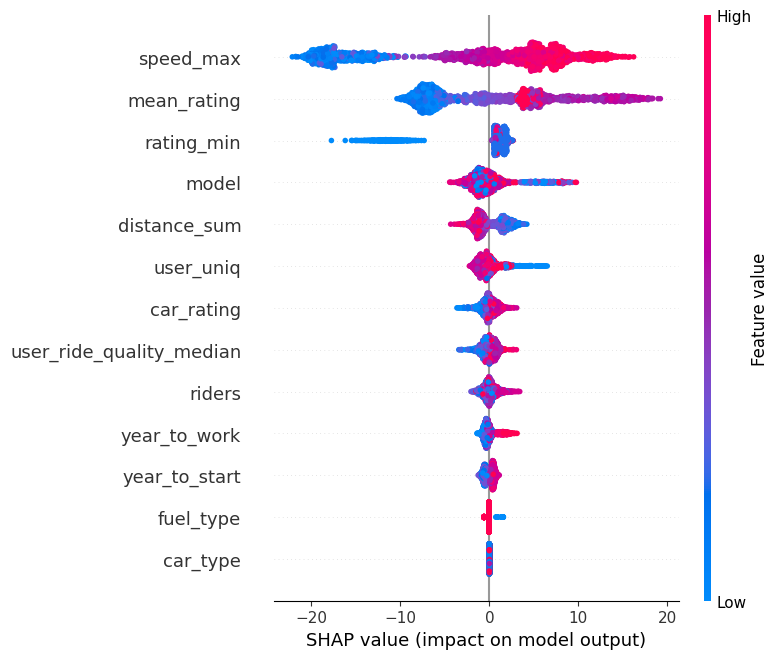

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_lgb)
shap.summary_plot(shap_values, X_lgb, max_display=25)

Уберём незанчительные признаки year_to_work и car_type.

In [ ]:
X_lgb.drop(['year_to_work', 'car_type'], axis=1, errors='ignore', inplace=True)
cat_features_tmp = ['model', 'fuel_type']

In [ ]:
lgb_init_params = {
    'boosting_type': 'goss',
    'n_jobs': -1,
    'metric': 'rmse',
    'objective': 'rmse',
    'random_state': RANDOM_STATE,
    'verbosity': -1,
    'device': 'cpu',
}


lgb_score, best_model = train_model(
    algorithm=LGBMRegressor,
    X=X_lgb, y=y,
    init_params=lgb_params_after_tuning,
    early_stopping_rounds=50,
    cat_features=cat_features_tmp,
    random_seed=RANDOM_STATE
)

best_model.save_model('lightgbm_raw.txt') #сохраняем модель

========= TRAINING LGBMRegressor =========
FOLD 0: SCORE 12.041936386314354
FOLD 1: SCORE 12.38134449649984
FOLD 2: SCORE 11.224492678691014

MEAN RMSE SCORE 11.4


Предсказание для лидерборда.

In [ ]:
lgb_test_pred = best_model.predict(test_encoded.drop(targets + feature2drop + ['year_to_work', 'car_type'], axis=1, errors='ignore'))

pd.DataFrame({'car_id': test['car_id'], 'target_reg': lgb_test_pred}).to_csv('lgb_pred_feature_selected.csv', index=False)

Получили RMSE = 12.1 на лидерборде.

### Вывод(маленький)

1) Подбор гиперпараметров значительно улучшил метрику.

2) Улучшения метрики удалось добиться отбором фичей. Видимо, модель основывалась не на самых информативных признаках.

## 🎯XGBoost (dart)

In [ ]:
X_xgb = train_encoded.drop(targets + feature2drop, axis=1, errors='ignore')
y = train_encoded['target_reg']

In [ ]:
xgb_init_params = {
    'enable_categorical': True,
    'booster': 'dart',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbosity': 0,
    'rate_drop': 0.1,
    'skip_drop': 0.5
}


xgb_score, best_model = train_model(
    algorithm=XGBRegressor,
    X=X_xgb, y=y,
    init_params=xgb_init_params,
    early_stopping_rounds=50,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

best_model.save_model('xgboost_raw.txt') #сохраняем модель

========= TRAINING XGBRegressor =========
FOLD 0: SCORE 11.869456348747926
FOLD 1: SCORE 12.411613337925157
FOLD 2: SCORE 11.44185110462802

MEAN RMSE SCORE 11.51


Предсказание для лидерборда.

In [ ]:
lgb_test_pred = best_model.predict(DMatrix(test_encoded.drop(targets + feature2drop, axis=1, errors='ignore')))

pd.DataFrame({'car_id': test['car_id'], 'target_reg': lgb_test_pred}).to_csv('xgb_pred_raw.csv', index=False)

Получили RMSE = 12.2 на лидерборде.

### Подбор гиперпараметров

In [ ]:
xgb_grid_params = {
    'max_depth': [3, 4, 5],
    'subsample': [0.9, 0.95, 1.0],
    'colsample_bytree': [0.9, 0.95, 1.0],
    'lambda': [0.5, 1, 1.5],
}#~243 варианта

xgb_fit_params = {
    'verbose': False
}


xgb_params_after_tuning = tuning_hyperparams(algorithm=XGBRegressor,
                                             X=X_xgb, y=y,
                                             init_params=xgb_init_params,
                                             fit_params=xgb_fit_params,
                                             grid_params=xgb_grid_params,
                                             n_iter=20,
                                             cv=3,
                                             random_state=RANDOM_STATE
)

xgb_params_after_tuning

{'subsample': 0.9,
 'max_depth': 3,
 'lambda': 1,
 'colsample_bytree': 0.95,
 'enable_categorical': True,
 'booster': 'dart',
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'random_state': 1337,
 'n_jobs': -1,
 'verbosity': 0,
 'rate_drop': 0.1,
 'skip_drop': 0.5}

Обучаем модель с лучшими параметрами.

In [ ]:
xgb_score, best_model = train_model(
    algorithm=XGBRegressor,
    X=X_xgb, y=y,
    init_params=xgb_params_after_tuning,
    early_stopping_rounds=50,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

best_model.save_model('xgboost_tuned.txt') #сохраняем модель

========= TRAINING XGBRegressor =========
FOLD 0: SCORE 11.870885797505688
FOLD 1: SCORE 12.866305942859512
FOLD 2: SCORE 11.305543444967315

MEAN RMSE SCORE 11.36


Предсказание для лидерборда.

In [ ]:
xgb_test_pred = best_model.predict(DMatrix(test_encoded.drop(targets + feature2drop, axis=1, errors='ignore')))

pd.DataFrame({'car_id': test['car_id'], 'target_reg': xgb_test_pred}).to_csv('xgb_pred_tuned.csv', index=False)

Получили RMSE = 12.2 на лидерборде.

### Feature Selection

Сначала посмотрим на каких признаках основывается модель. Особенность xgboosta - он может отображать не все фичи в feature_importance. Можно считать неотображённые фичи нименее важными. Самыми неважными оказались year_to_start и year_to_work.

В данном случае это не моя ошибка т.к. предикт он делает на 13 фичах. [Ссылка](https://github.com/dmlc/xgboost/issues/4324) на обсуждение этой проблемы.

In [ ]:
feature_importance = best_model.get_score(importance_type='weight')

importance_df = pd.DataFrame({'Feature': list(feature_importance.keys()), 'Importance': list(feature_importance.values())}).sort_values('Importance', ascending=False, ignore_index=True).round(1)

importance_df

,Feature,Importance
0,speed_max,19.0
1,mean_rating,17.0
2,rating_min,10.0
3,fuel_type,7.0
4,model,4.0
5,distance_sum,3.0
6,user_ride_quality_median,3.0
7,user_uniq,3.0
8,riders,2.0
9,car_type,1.0


В этот раз попробуем permutation importance.

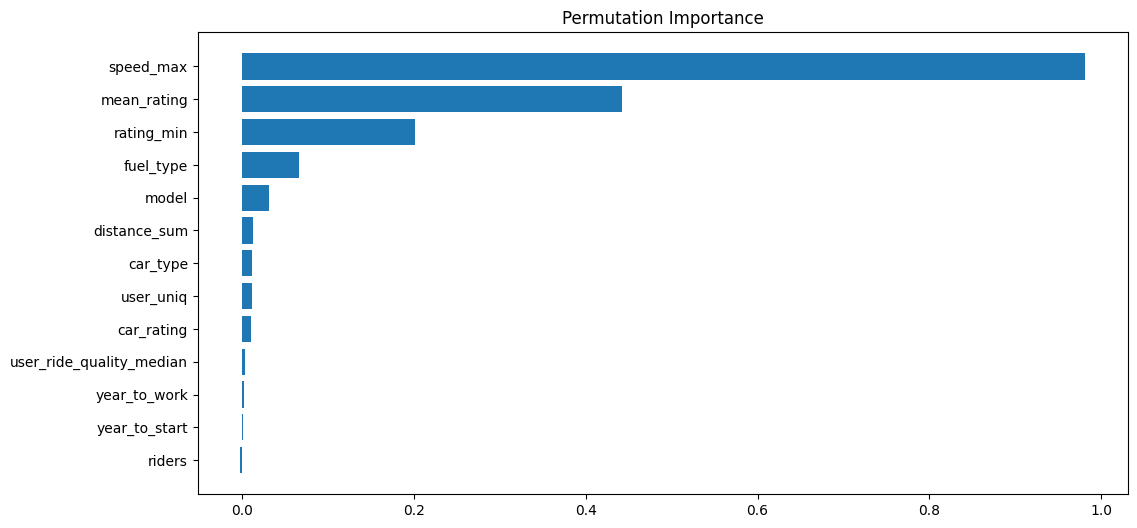

In [ ]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt

X_train, X_valid, y_train, y_valid = train_test_split(X_xgb, y, test_size=0.2, random_state=RANDOM_STATE)

train_dataset = DMatrix(data=X_train, label=y_train)
eval_dataset = DMatrix(data=X_valid, label=y_valid)

model = XGBRegressor(**xgb_params_after_tuning)
model.fit(X_train, y_train)

perm_importance = permutation_importance(model, X_valid, y_valid, n_repeats=10, random_state=RANDOM_STATE)
sorted_idx = perm_importance.importances_mean.argsort()

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_xgb.columns)[sorted_idx])
plt.title('Permutation Importance');



Удалим 4 худших фичи.

In [ ]:
low_inf_cols = ['riders', 'year_to_start', 'year_to_work', 'user_ride_quality_median']

xgb_score, best_model = train_model(
    algorithm=XGBRegressor,
    X=X_xgb.drop(low_inf_cols, axis=1, errors='ignore'), y=y,
    init_params=xgb_params_after_tuning,
    early_stopping_rounds=50,
    cat_features=cat_features,
    random_seed=RANDOM_STATE
)

best_model.save_model('xgboost_feature_selected.txt') #сохраняем модель

========= TRAINING XGBRegressor =========
FOLD 0: SCORE 11.927348534978194
FOLD 1: SCORE 12.566565917424919
FOLD 2: SCORE 11.322808404312875

MEAN RMSE SCORE 11.43


Предсказание для лидерборда.

In [ ]:
xgb_test_pred = best_model.predict(DMatrix(test_encoded.drop(targets + feature2drop + low_inf_cols, axis=1, errors='ignore')))

pd.DataFrame({'car_id': test['car_id'], 'target_reg': xgb_test_pred}).to_csv('xgb_pred_feature_selected.csv', index=False)

Получили RMSE = 12.1 на лидерборде. Просели на вале, но поднялись на лидерборде.

### Вывод(маленький)

1) Подбор гиперпараметров улучшил метрику.

2) Улучшения метрики удалось добиться отбором фичей.

### Объединение лучших моделей

 Объединим предсказания лучших моделей с одинаковыми весами.

In [ ]:
pred = 1/3 * pd.read_csv('/content/xgb_pred_feature_selected.csv')['target_reg'] + \
1/3 * pd.read_csv('/content/lgb_pred_feature_selected.csv')['target_reg'] + \
1/3 * pd.read_csv('/content/cb_pred_feature_selected.csv')['target_reg']

In [ ]:
pd.DataFrame({'car_id': test['car_id'], 'target_reg': pred}).to_csv('best_pred.csv', index=False)

Получили RMSE = 11.8 на лидерборде.

Увеличим вес у лучшей модели - catboosta.

In [ ]:
pred = 4/10 * pd.read_csv('/content/xgb_pred_feature_selected.csv')['target_reg'] + \
3/10 * pd.read_csv('/content/lgb_pred_feature_selected.csv')['target_reg'] + \
3/10 * pd.read_csv('/content/cb_pred_feature_selected.csv')['target_reg']

In [ ]:
pd.DataFrame({'car_id': test['car_id'], 'target_reg': pred}).to_csv('best_pred_w.csv', index=False)

Получили RMSE = 11.9 на лидерборде.

## Выводы

**Подбор гиперпараметров**

Из за маленьких вычислительных мощностей пришлось делать маленький перебор параметров. Как следствие значительный прирост метрики после тюнинга был только у LightGBM.

**Feature selection**

Признак deviation_normal_count оказался константой и был удалён сразу.

Использовались 2 метода отбора фичей.
1. Индекс Шепли двумя способами - встроеный в кэтбуст и с помощью библиотеки shap.
2. Permutation importance.

Хужшими фичами оказались:

1. year_to_start, car_rating, riders
2. year_to_work и car_type
3. riders, year_to_start, year_to_work и user_ride_quality_median

Во всех случаях удаление худших фичей увеличило метрику.

**Модели**

Лучшей моделью оказался catboost. Из коробки удалось пробить порог rmse = 12.
Остальные 2 бустинга набрали 12.1 в лучшем случае.

Объединение лучших моделей дало 11.8. Объединение с весами только ухудшило ситуацию и дало 11.9.